<a href="https://colab.research.google.com/github/hotdog1029/deeplearning/blob/main/%EC%98%B7_%EC%A2%85%EB%A5%98_%EB%8D%B0%EC%9D%B4%ED%84%B0_FashionMNIST%EB%A5%BC_%ED%99%9C%EC%9A%A9%ED%95%B4_AutoEncoder_%EC%84%A4%EA%B3%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoEncoder(AE)
회귀와 분류모델은 지도학습으로, 신경망 모델은 처음에 이 지도학습을 위해 개발되었다. 그러나 신경망 모델의 학습 알고리즘의 특성상 다른 방식으로도 (비지도학습) 개발 되기 시작하였다. GAN(Generative Adversarial Network)도 그중 하나이다. AE는 대표적인 비지도학습 신경망 모델이다. AE의 학습 과정은 데이터를 원래의 데이터로 잘 복원하도록 학습시키는 것으로 이해할 수 있다. 

In [48]:
# 1. Module Import
import numpy as np    # 선형 대수 관련된 함수를 쉽게 이용할 수 있는 모듈이며 대부분 파이썬 코드 스크립트에서 가장 자주 언급되는 모듈이다.
import matplotlib.pyplot as plt # 함수 실행 결과 산출물에 대한 수치에 대해 사람이 쉽게 이해할 수 있도록 시각화할 수 있는 외부 모듈이다.

import torch # 파이토치의 기본 모듈
import torch.nn as nn # 파아토치 모듈 중 딥러닝, 즉 인공 신경망 모델을 설계하는 데 필요한 함수를 모아 놓은 모듈이다.
import torch.nn.functional as F # torch.nn 모듈 중에서도 자주 이용되는 함슈를 F 로 지정한다.
from torchvision import transforms, datasets #  컴퓨터 비전 연구 분야에서 자주 이용되는 torchvision 모듈 내의 transforms, datasets 함수를 임포트 한 것이다.

In [47]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else:
  DEVICE = torch.device('cup')
print('사용하는 파이토치 버전: ',torch.__version__, 'Device: ',DEVICE)

사용하는 파이토치 버전:  1.7.0+cu101 Device:  cuda


In [46]:
BATCH_SIZE = 32  # 미니배치 1개에 데이터가 32개로 구성돼 있는 것을 말함, 미니배치를 통해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습을 진행한 회수를 'EPOCH'
EPOCH = 10 # 미니배치를 전부 이용하는 횟수를 의미

In [66]:
# 3. FashionMINST 데이터 다운로드(train set, test set 분리하기)        # root: 데이터가 저장될 장소, train: 학습용데이터인지 검증용 데이터인지 지정함
train_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',   # download: 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지를 지정
                                      train = True,                    # transform: 사람의 손글씨 데이터인 MNIST는 이미지 데이터이다. 이 데이터를 tensor 형태로 변환해줌
                                      download = True,                 # dataset: 미니배치 단위로 할당하고자 하는 데이터셋을 지정
                                      transform = transforms.ToTensor())    # shuffle: 데이터의 순서를 섞고자 할 때 이용, 잘못된 방향으로 학습하는 것을 방지하기 위해 데이터 순서를 섞어주기도 한다.
test_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',
                                      train = False,
                                      download = True,
                                      transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

In [44]:
# 4. 데이터 확인하기 (1)
for(x_train, y_train) in train_loader:
  print('x_trian: ',x_train.size(),x_train.type()) # 32개의 이미지 데이터가 1개의 미니배치를 구성하고 있고 가로 28개, 세로 28개의 픽셀로 구성돼 있으며 채널이 1이므로 흑백으로 이루어진 이미지
                                                   # 데이터 라는 것을 알 수 있다.
  print('y_trian: ',y_train.size(),y_train.type()) # 32개의 이미지 데이터 label 값이 1개씩 존재하기 떄문에 32개의 값을 지니고 있다는 것을 볼 수 있다.
  break

x_trian:  torch.Size([32, 1, 28, 28]) torch.FloatTensor
y_trian:  torch.Size([32]) torch.LongTensor


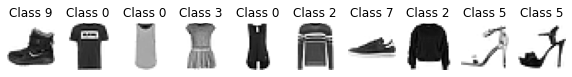

In [43]:
# 5. 데이터 확인하기 (2)
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
  plt.subplot(1, 10, i+1)
  plt.axis('off')
  plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap = 'gray_r')
  plt.title('Class '+ str(y_train[i].item()))

데이터가 실제로 어떻게 생겼는지 사람의 눈으로 확인할 수 있도록 시각화하는 코드이다.

[미니배치,채널,세로,가로]의 형태, 즉 1개의 미니배치 내에는 32개의 데이터가 있고 채널이 1개이며 세로 28, 가로 28인 이미지 데이터를 의미하는 [32,1,28,28] 데이터 모양을 사람의 눈으로 직접 확인할 수 있도록 이미지 데이터를 시각화하거나 [세로,가로,채널] 헝태로 변환하기 위해 [28,28,1]로 각각 변환해 시각화 한다.
제시된 10개의 이미지 데이터 각각은 28*28*1 개의 픽셀로 구성돼 있는 이미지이고 각 이미지별로 할당된 label 값 역시 올바르게 매칭돼 있다는 것을 확인할 수 있다.

In [42]:
# 6. AutoEncoder(AE) 모델 설계하기
class AE(nn.Module):  # 파이토치 모듈 내에 딥러닝 모델 관련 기본 함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스를 정의한다. nn.Module 클래스를 상속받았을 때 nn.Module 클래스가
                      # 이용할 수 있는 함수를 그대로 이용할 수 있기 때문에 자주 이용됨
  def __init__(self): # AE 클래스의 인스턴스를 생성했을 때 지니게 되는 성질을 정의해주는 메서드이다.
    super(AE,self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용한다.

    self.encoder = nn.Sequential( # AE는 인코더와 디코더로 이루어져 있는데 그중 인코더를 정의하는 부분으로, 기존에는 def __init__(self)를 이용해 모델을 설계하는 데 필요한 요소를 사전에
                                  # 정의한 후 forward() 부분에서 호출해 사용했다면 이번에는 nn.Sequential()을 이용해 인코더 단위를 한번에 정의 하였다.
        nn.Linear(28 * 28, 512), # FashionMNIS 데이터는 28 * 28 크기의 이미지 데이터이므로 해당 이미지 데이터를 입력받을 수 있도록 노드수를 28*28로 설정한다. 그리고 output의 크기는 512
        nn.ReLU(), # AE의 인코더 부분 첫 번째 레이어의 output에 대해 ReLU() 비선형 함수를 이용해 두 번째 레이어의 input으로 전달한다
        nn.Linear(512,256), # 인코더 부분 두 번째 레이어
        nn.ReLU(), # 두 번째 레이어 ouput에 대해 랠루 함수 적용해 세 번째 레이어 input으로 전달
        nn.Linear(256,32),) # 인코더 부분 세 번째 레이어
    
    self.decoder = nn.Sequential(  # 디코더 부분
        nn.Linear(32, 256),
        nn.ReLU(),
        nn.Linear(256,512),
        nn.ReLU(),
        nn.Linear(512,28 * 28),)
    
  def forward(self,x): # 앞에서 정의한 AE의 인코더,디코더에 대해 Forward Propagation을 정의 
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [56]:
# 7. Opimizer, Objective Function 설정

model = AE().to(DEVICE)  # 앞에서 정의한 AE 모델을 기존에 선정한 DEVICE에 할당한다. 그 이유는 DEVICE 장비를 이용해 AE 모델을 완성하기 위해서이다.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # Back Propagation을 통해 파라미터를 업데이트할 때 이용하는 optimizer을 정의한다. 이 예제에서는 Adam 알고리즘 사용
criterion = nn.MSELoss() # AE 모델의 output 값은 input으로 이용된 이미지 데이터와 복원된 이미지 데이터 값 간의 MeanSquaredError를 이용해 계산하기 위해 criterion은 nn.MSELoss()로 설정

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [63]:
# 8. AE 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(model,train_loader, optimizer, log_interval): # AE 모델을 설계했으므로 기존에 정의한 이미지 데이터와 레이블 데이터를 이용해 MLP모델을 학습하는 train 함수 정의
  model.train() # 기존에 정의한 AE 모델을 학습 상태로 지정
  for batch_idx,(image, _) in enumerate(train_loader): # train_loader 내의 미니배치 단위로 저장된 데이터를 순서대로 이용해 AE 모형을 학습, 이 예제에서는 레이블 데이터를 활용해 학습하는 것이
                                                       # 아니라 입력 데이터를 타깃으로 학습하기 때문에 레이블 데이터를 이용할 필요가 없다. 그래서 Label 값을 _로 대신 설정해 생략함
    image = image.view(-1,28*28).to(DEVICE) # 미니 배치 내에 있는 이미지 데이터를 기존에 정의한 장비에 할당, 이때 기존의 정의한 AE의 input은 28*28 크기의 1차원 레이어이므로 2차원 이미지데이터를
                                            # 1차원 데이터로 재구성해 할당해야 한다.
    target = image.view(-1,28*28).to(DEVICE) # 미니 배치 내에 있는 이미지 데이터를 AE의 output과 비교하는 대상으로 설정하기 위해 기존에 정의한 장비에 할당
    optimizer.zero_grad() # optimizer의 gradient를 초기화
    encoded, decoded = model(image)
    loss = criterion(decoded, target) # 계산된 output과 장비에 할당된 이미지 데이터의 Loss 값 계산
    loss.backward() # Loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradient 값을 각 파라미터에 할당
    optimizer.step() # 파라미터 값을 업데이트
    
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{}({:.0f}%(]\tTrain Loss: {:.6f}'.format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()))

In [39]:
# 9. 학습되는 과정 속ㅇ서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
  model.eval() # 학습 과정 속 또는 학습이 완료된 AE 모델을 학습 상태가 아닌, 평가 상태로 지정
  test_loss = 0
  real_image = []
  gen_image = []
  with torch.no_grad(): # AE 모델을 평가하는 단계에서는 Gradient를 통해 파라미터 값이 업데이트되는 현상을 방지하기 위해 torch.no_grad() 메서드를 이용
    for image, _ in test_loader: # 미니 배치 내에 있는 이미지 데이터에 반복을 이용해 차례대로 접근
      image = image.view(-1,28*28).to(DEVICE)
      target = image.view(-1,28*28).to(DEVICE)
      encoded, decoded = model(image)

      test_loss += criterion(decoded, image).item() # test_loss 값을 업데이트
      real_image.append(image.to('cpu')) # 실제 이미지로 할당된 이미지를 리스트에 추가
      gen_image.append(decoded.to('cpu')) # AE 모델을 통해 생성된 이미지를 리스트에 추가

  test_loss /= len(test_loader.dataset) # 현재까지 계산된 test_loss 값을 test_loader 내에 있는 미니배치 개수만큼 나눠 평균 Loss 값을 게산
  return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%(]	Train Loss: 0.009999
Train Epoch: 1 [6400/60000(11%(]	Train Loss: 0.009791
Train Epoch: 1 [12800/60000(21%(]	Train Loss: 0.008853
Train Epoch: 1 [19200/60000(32%(]	Train Loss: 0.007345
Train Epoch: 1 [25600/60000(43%(]	Train Loss: 0.008731
Train Epoch: 1 [32000/60000(53%(]	Train Loss: 0.008399
Train Epoch: 1 [38400/60000(64%(]	Train Loss: 0.013269
Train Epoch: 1 [44800/60000(75%(]	Train Loss: 0.008453
Train Epoch: 1 [51200/60000(85%(]	Train Loss: 0.010453
Train Epoch: 1 [57600/60000(96%(]	Train Loss: 0.008454

[EPOCH: 1], 	Test Loss: 0.0003


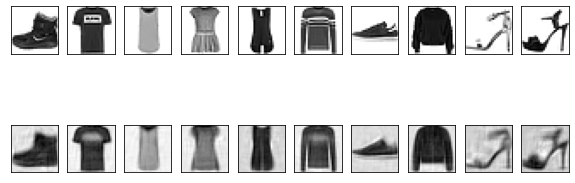

Train Epoch: 2 [0/60000(0%(]	Train Loss: 0.007705
Train Epoch: 2 [6400/60000(11%(]	Train Loss: 0.009026
Train Epoch: 2 [12800/60000(21%(]	Train Loss: 0.008279
Train Epoch: 2 [19200/60000(32%(]	Train Loss: 0.009436
Train Epoch: 2 [25600/60000(43%(]	Train Loss: 0.007346
Train Epoch: 2 [32000/60000(53%(]	Train Loss: 0.009798
Train Epoch: 2 [38400/60000(64%(]	Train Loss: 0.008420
Train Epoch: 2 [44800/60000(75%(]	Train Loss: 0.008524
Train Epoch: 2 [51200/60000(85%(]	Train Loss: 0.008955
Train Epoch: 2 [57600/60000(96%(]	Train Loss: 0.009403

[EPOCH: 2], 	Test Loss: 0.0003


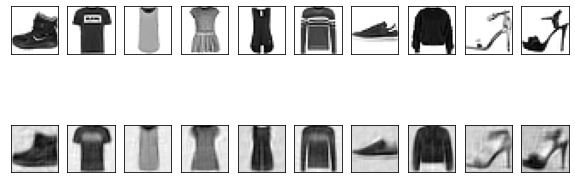

Train Epoch: 3 [0/60000(0%(]	Train Loss: 0.009787
Train Epoch: 3 [6400/60000(11%(]	Train Loss: 0.008792
Train Epoch: 3 [12800/60000(21%(]	Train Loss: 0.008196
Train Epoch: 3 [19200/60000(32%(]	Train Loss: 0.010219
Train Epoch: 3 [25600/60000(43%(]	Train Loss: 0.008599
Train Epoch: 3 [32000/60000(53%(]	Train Loss: 0.009876
Train Epoch: 3 [38400/60000(64%(]	Train Loss: 0.010738
Train Epoch: 3 [44800/60000(75%(]	Train Loss: 0.009944
Train Epoch: 3 [51200/60000(85%(]	Train Loss: 0.007908
Train Epoch: 3 [57600/60000(96%(]	Train Loss: 0.010450

[EPOCH: 3], 	Test Loss: 0.0003


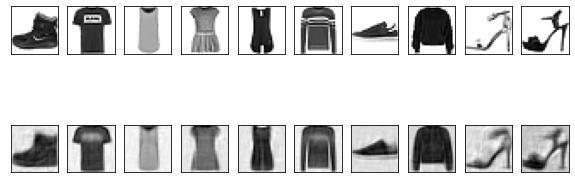

Train Epoch: 4 [0/60000(0%(]	Train Loss: 0.009621
Train Epoch: 4 [6400/60000(11%(]	Train Loss: 0.009069
Train Epoch: 4 [12800/60000(21%(]	Train Loss: 0.009173
Train Epoch: 4 [19200/60000(32%(]	Train Loss: 0.007472
Train Epoch: 4 [25600/60000(43%(]	Train Loss: 0.008961
Train Epoch: 4 [32000/60000(53%(]	Train Loss: 0.008939
Train Epoch: 4 [38400/60000(64%(]	Train Loss: 0.008091
Train Epoch: 4 [44800/60000(75%(]	Train Loss: 0.009461
Train Epoch: 4 [51200/60000(85%(]	Train Loss: 0.007733
Train Epoch: 4 [57600/60000(96%(]	Train Loss: 0.008261

[EPOCH: 4], 	Test Loss: 0.0003


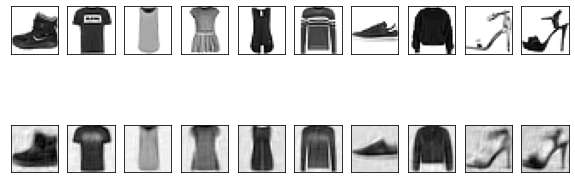

Train Epoch: 5 [0/60000(0%(]	Train Loss: 0.008346
Train Epoch: 5 [6400/60000(11%(]	Train Loss: 0.009732
Train Epoch: 5 [12800/60000(21%(]	Train Loss: 0.009578
Train Epoch: 5 [19200/60000(32%(]	Train Loss: 0.010504
Train Epoch: 5 [25600/60000(43%(]	Train Loss: 0.008193
Train Epoch: 5 [32000/60000(53%(]	Train Loss: 0.009031
Train Epoch: 5 [38400/60000(64%(]	Train Loss: 0.008528
Train Epoch: 5 [44800/60000(75%(]	Train Loss: 0.008140
Train Epoch: 5 [51200/60000(85%(]	Train Loss: 0.009309
Train Epoch: 5 [57600/60000(96%(]	Train Loss: 0.010362

[EPOCH: 5], 	Test Loss: 0.0003


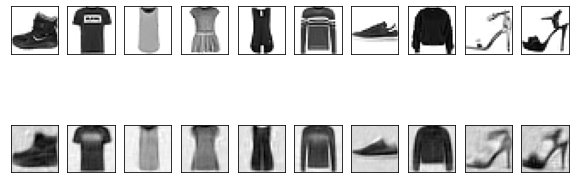

Train Epoch: 6 [0/60000(0%(]	Train Loss: 0.007858
Train Epoch: 6 [6400/60000(11%(]	Train Loss: 0.009304
Train Epoch: 6 [12800/60000(21%(]	Train Loss: 0.008505
Train Epoch: 6 [19200/60000(32%(]	Train Loss: 0.009801
Train Epoch: 6 [25600/60000(43%(]	Train Loss: 0.009810
Train Epoch: 6 [32000/60000(53%(]	Train Loss: 0.009490
Train Epoch: 6 [38400/60000(64%(]	Train Loss: 0.008806
Train Epoch: 6 [44800/60000(75%(]	Train Loss: 0.009745
Train Epoch: 6 [51200/60000(85%(]	Train Loss: 0.010349
Train Epoch: 6 [57600/60000(96%(]	Train Loss: 0.007933

[EPOCH: 6], 	Test Loss: 0.0003


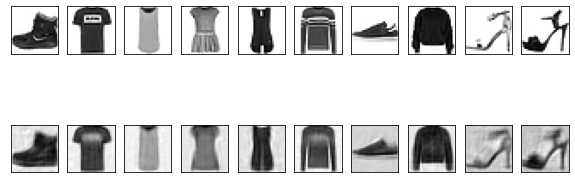

Train Epoch: 7 [0/60000(0%(]	Train Loss: 0.008894
Train Epoch: 7 [6400/60000(11%(]	Train Loss: 0.011238
Train Epoch: 7 [12800/60000(21%(]	Train Loss: 0.009855
Train Epoch: 7 [19200/60000(32%(]	Train Loss: 0.006973
Train Epoch: 7 [25600/60000(43%(]	Train Loss: 0.008517
Train Epoch: 7 [32000/60000(53%(]	Train Loss: 0.008460
Train Epoch: 7 [38400/60000(64%(]	Train Loss: 0.011101
Train Epoch: 7 [44800/60000(75%(]	Train Loss: 0.010193
Train Epoch: 7 [51200/60000(85%(]	Train Loss: 0.009098
Train Epoch: 7 [57600/60000(96%(]	Train Loss: 0.010893

[EPOCH: 7], 	Test Loss: 0.0003


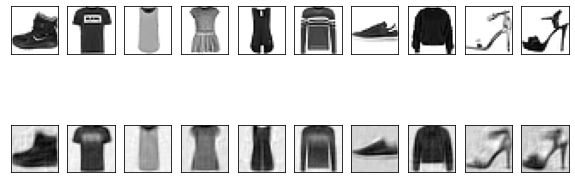

Train Epoch: 8 [0/60000(0%(]	Train Loss: 0.009544
Train Epoch: 8 [6400/60000(11%(]	Train Loss: 0.012158
Train Epoch: 8 [12800/60000(21%(]	Train Loss: 0.008185
Train Epoch: 8 [19200/60000(32%(]	Train Loss: 0.009847
Train Epoch: 8 [25600/60000(43%(]	Train Loss: 0.009024
Train Epoch: 8 [32000/60000(53%(]	Train Loss: 0.007631
Train Epoch: 8 [38400/60000(64%(]	Train Loss: 0.009034
Train Epoch: 8 [44800/60000(75%(]	Train Loss: 0.008599
Train Epoch: 8 [51200/60000(85%(]	Train Loss: 0.008766
Train Epoch: 8 [57600/60000(96%(]	Train Loss: 0.009293

[EPOCH: 8], 	Test Loss: 0.0003


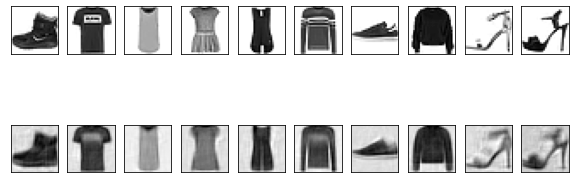

Train Epoch: 9 [0/60000(0%(]	Train Loss: 0.007863
Train Epoch: 9 [6400/60000(11%(]	Train Loss: 0.009055
Train Epoch: 9 [12800/60000(21%(]	Train Loss: 0.007187
Train Epoch: 9 [19200/60000(32%(]	Train Loss: 0.009042
Train Epoch: 9 [25600/60000(43%(]	Train Loss: 0.009228
Train Epoch: 9 [32000/60000(53%(]	Train Loss: 0.010082
Train Epoch: 9 [38400/60000(64%(]	Train Loss: 0.010006
Train Epoch: 9 [44800/60000(75%(]	Train Loss: 0.009414
Train Epoch: 9 [51200/60000(85%(]	Train Loss: 0.006922
Train Epoch: 9 [57600/60000(96%(]	Train Loss: 0.010272

[EPOCH: 9], 	Test Loss: 0.0003


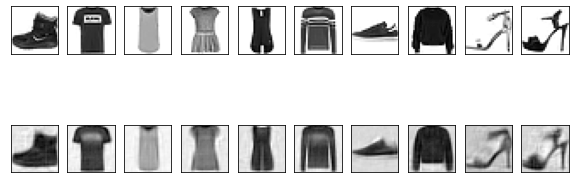

Train Epoch: 10 [0/60000(0%(]	Train Loss: 0.008638
Train Epoch: 10 [6400/60000(11%(]	Train Loss: 0.008754
Train Epoch: 10 [12800/60000(21%(]	Train Loss: 0.007545
Train Epoch: 10 [19200/60000(32%(]	Train Loss: 0.009385
Train Epoch: 10 [25600/60000(43%(]	Train Loss: 0.008378
Train Epoch: 10 [32000/60000(53%(]	Train Loss: 0.008651
Train Epoch: 10 [38400/60000(64%(]	Train Loss: 0.008513
Train Epoch: 10 [44800/60000(75%(]	Train Loss: 0.010084
Train Epoch: 10 [51200/60000(85%(]	Train Loss: 0.009744
Train Epoch: 10 [57600/60000(96%(]	Train Loss: 0.007986

[EPOCH: 10], 	Test Loss: 0.0003


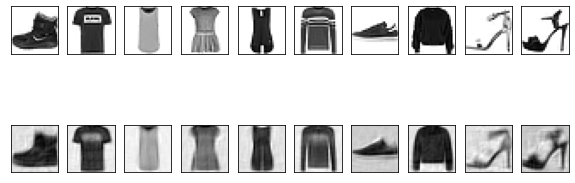

In [71]:
# 10. AE 학습을 실행하며 test set의 Reconstruction Error 확인
for Epoch in range(1, EPOCH+1):
  train(model, train_loader, optimizer, log_interval = 200)
  test_loss, real_image, gen_image = evaluate(model, test_loader)
  print('\n[EPOCH: {}], \tTest Loss: {:.4f}'.format(Epoch, test_loss))
  f, a = plt.subplots(2, 10, figsize =(10, 4))
  for i in range(10):
    img = np.reshape(real_image[0][i],[28,28])
    a[0][i].imshow(img, cmap = 'gray_r')
    a[0][i].set_xticks(())
    a[0][i].set_yticks(())
  for i in range(10):
    img = np.reshape(gen_image[0][i],[28,28])
    a[1][i].imshow(img, cmap = 'gray_r')
    a[1][i].set_xticks(())
    a[1][i].set_yticks(())
  plt.show()